# Desafio

Seu objetivo é identificar quais máquinas apresentam potencial de falha tendo como base dados extraídos através de sensores durante o processo de manufatura.  Para isso são fornecidos dois datasets: um dataset chamado desafio_manutencao_preditiva_treino composto por 6667 linhas, 9 colunas de informação (features) e a variável a ser prevista (“failure_type”).

Participante: Victor Afonso Bauler

# Sumário Executivo



- Estatísticas descritivas escolhidas:
    - Média, desvio padrão, correlação, IQR, valores mais frequentes.
    - Com base nas estátisticas citadas acima, foi possível observar que o dataset é extremamente desbalanceado (96,5 % das linhas são da classe "No Fault"). Além disso, foi possível observar por meio dos boxplots as tendências citadas no dicionário dos dados a respeito de cada falha, e posteriormente foram criadas novas features para tentar melhorar a previsão do tipo de falha.

<br/>

- Previsão do tipo de falha:
    - A solução de como realizar a previsão do tipo de falha foi detalhada em passo a passo no notebook, sendo que foram utilizadas todas as features fornecidas no dataset para previsão da variável alvo "failure_type", com exceção das features "udi" e "product_id" as quais não foram utilizadas pois representam um identificador único de cada máquina e não agregam valor para a previsão da variável alvo. Além disso, foram geradas 4 novas features com base na descrição dos dados de falha fornecidos ("power", "temp_diff", "overstrain" e "tool_wear_range").
    - O problema a ser resolvido é um problema de classificação multiclasse, e o melhor modelo obtido com base na métrica escolhida foi o RandomForest.
    - Métrica escolhida: Macro F1 Score, pois é uma métrica que considera a precisão e o recall de cada classe, e é uma métrica que atribui o mesmo peso para todas as classes, como nosso dataset é desbalanceado não faria muito sentido utilizar a acurácia do modelo.

<br/>

- Resultados:
    - Separando o dataset de treino em treino (80%) e validação(20%).
    - Foi obtido um Macro F1 Score de 0.665 para o modelo RandomForest, com a seguinte matriz de confusão:

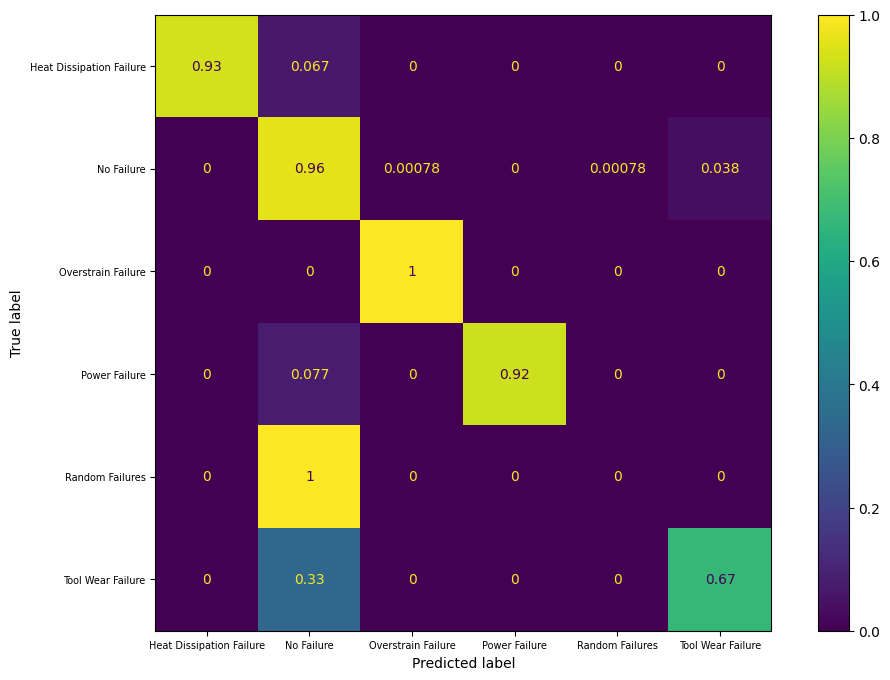

In [160]:
create_confusion_matrix(y_val, y_pred, gs_rf.best_estimator_.classes_)

# Solução

## 1 - Importando bibliotecas necessárias

Esta etapa consiste em importar as bibliotecas utilizadas no projeto.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from sklearn.experimental import enable_halving_search_cv

from sklearn.exceptions import ConvergenceWarning
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier

## 2 - Carregamentos dos dados e checagem preliminar

Durante esta etapa é realizada a leitura dos datasets fornecidos e checagem de valores faltantes e duplicados, buscando verificar se existe algum tipo de problema nos dados fornecidos.

Como os dados de teste fornecidos não estão rotulados, para mensurar a performance dos modelos treinados, será necessário dividir o dataset de treino em treino e teste. Para não gerar confusão na análise, os dados de teste (criados a partir do dataset de treino) serão chamados de validação (lembrando que o nome validação na literatura remete aos dados utilizados para otimizar os hiperparâmetros dos modelos, mas neste caso será para avaliar sua performance ao final do treinamento). Ou seja, df_val = dataset de validação.

In [103]:
# Definindo o diretório raiz
ROOT_DIR = os.path.dirname(os.path.abspath(''))

# Carregando os dados
df_train = pd.read_csv(f'{ROOT_DIR}/data/desafio_manutencao_preditiva_treino.csv')
df_test = pd.read_csv(f'{ROOT_DIR}/data/desafio_manutencao_preditiva_teste.csv')

# Verificando a quantidade de linhas e colunas
print(df_train.shape, df_test.shape)

(6667, 9) (3333, 8)


In [3]:
# Analisando dados faltantes
print(f"Dados faltantes no dataset de treino \n{df_train.isna().sum()}\n")
print(f"Dados faltantes no dataset de teste \n{df_test.isna().sum()}")

Dados faltantes no dataset de treino 
udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
failure_type             0
dtype: int64

Dados faltantes no dataset de teste 
udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
dtype: int64


In [4]:
# Analisando dados duplicados
print(f"Dados duplicados no dataset de treino \n{df_train.duplicated().sum()}\n")
print(f"Dados duplicados no dataset de teste \n{df_test.duplicated().sum()}")

Dados duplicados no dataset de treino 
0

Dados duplicados no dataset de teste 
0


In [104]:
# Criando dataset de validação

df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=30, stratify=df_train['failure_type'])

df_train.shape, df_val.shape

((5333, 9), (1334, 9))

## 3 - Análise Exploratória

Durante esta etapa, o objetivo é entender melhor o conjunto de dados que estamos trabalhando. É importante lembrar que essa análise deve ser realizada apenas com o conjunto de dados de treinamento, pois é nele que vamos encontrar as tendências e relações que serão utilizadas para treinar nosso modelo. Analisar o conjunto de dados de teste (nesse caso validação) pode levar a vieses e distorções na análise, pois esses dados devem ser reservados para avaliar a performance do modelo treinado. Isso inclui verificar as características dos dados, como o número de amostras, atributos e tipos de dados, bem como identificar possíveis problemas como valores ausentes ou outliers. Para realização desta análise, serão utilizadas bibliotecas de visualização de dados e estatísticas descritivas.

### a) Estatísticas Descritivas

#### i) Variáveis numéricas

In [4]:
numerical_features = df_train.select_dtypes(include=['int64', 'float64']).columns
numerical_features = numerical_features.drop('udi')

# Estatísticas descritivas das variáveis numéricas
df_train[numerical_features].describe()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
count,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000
mean,299.992515,309.992620,1537.419529,40.058512,108.098095
std,1.994710,1.488101,177.182908,9.950804,63.359915
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1422.500000,33.200000,54.000000
50%,300.000000,310.000000,1503.000000,40.200000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,251.000000


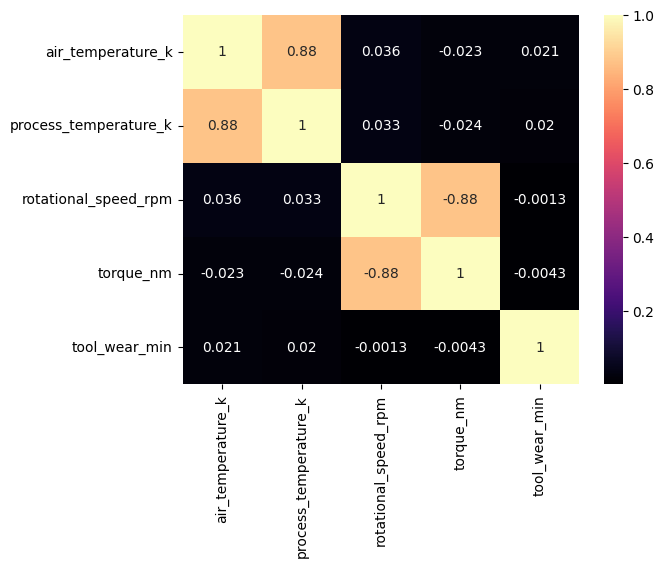

In [5]:
# Correlação entre as variáveis numéricas
corr = df_train[numerical_features].corr(numeric_only=True)
sns.heatmap(corr.abs(), annot=corr, cmap='magma');

#### ii) Variáveis categóricas

In [6]:
categorical_features = df_train.select_dtypes(include=['object']).columns
categorical_features = categorical_features.drop('product_id')

# Estatísticas descritivas das variáveis categóricas
df_train[categorical_features].describe()

,type,failure_type
count,6667,6667
unique,3,6
top,L,No Failure
freq,4022,6435


É possível notar que o dataset é extremamente desbalanceado de forma que 96,5% dos dados são rotulados sem defeito, sendo assim, na parte de modelagem será necessário aplicar métricas de avaliação que suportam esse tipo de problema, como score F1 e acurácia balanceada. 

### b) Plots de distribuições com varíavel de saída

#### i) Variáveis numéricas

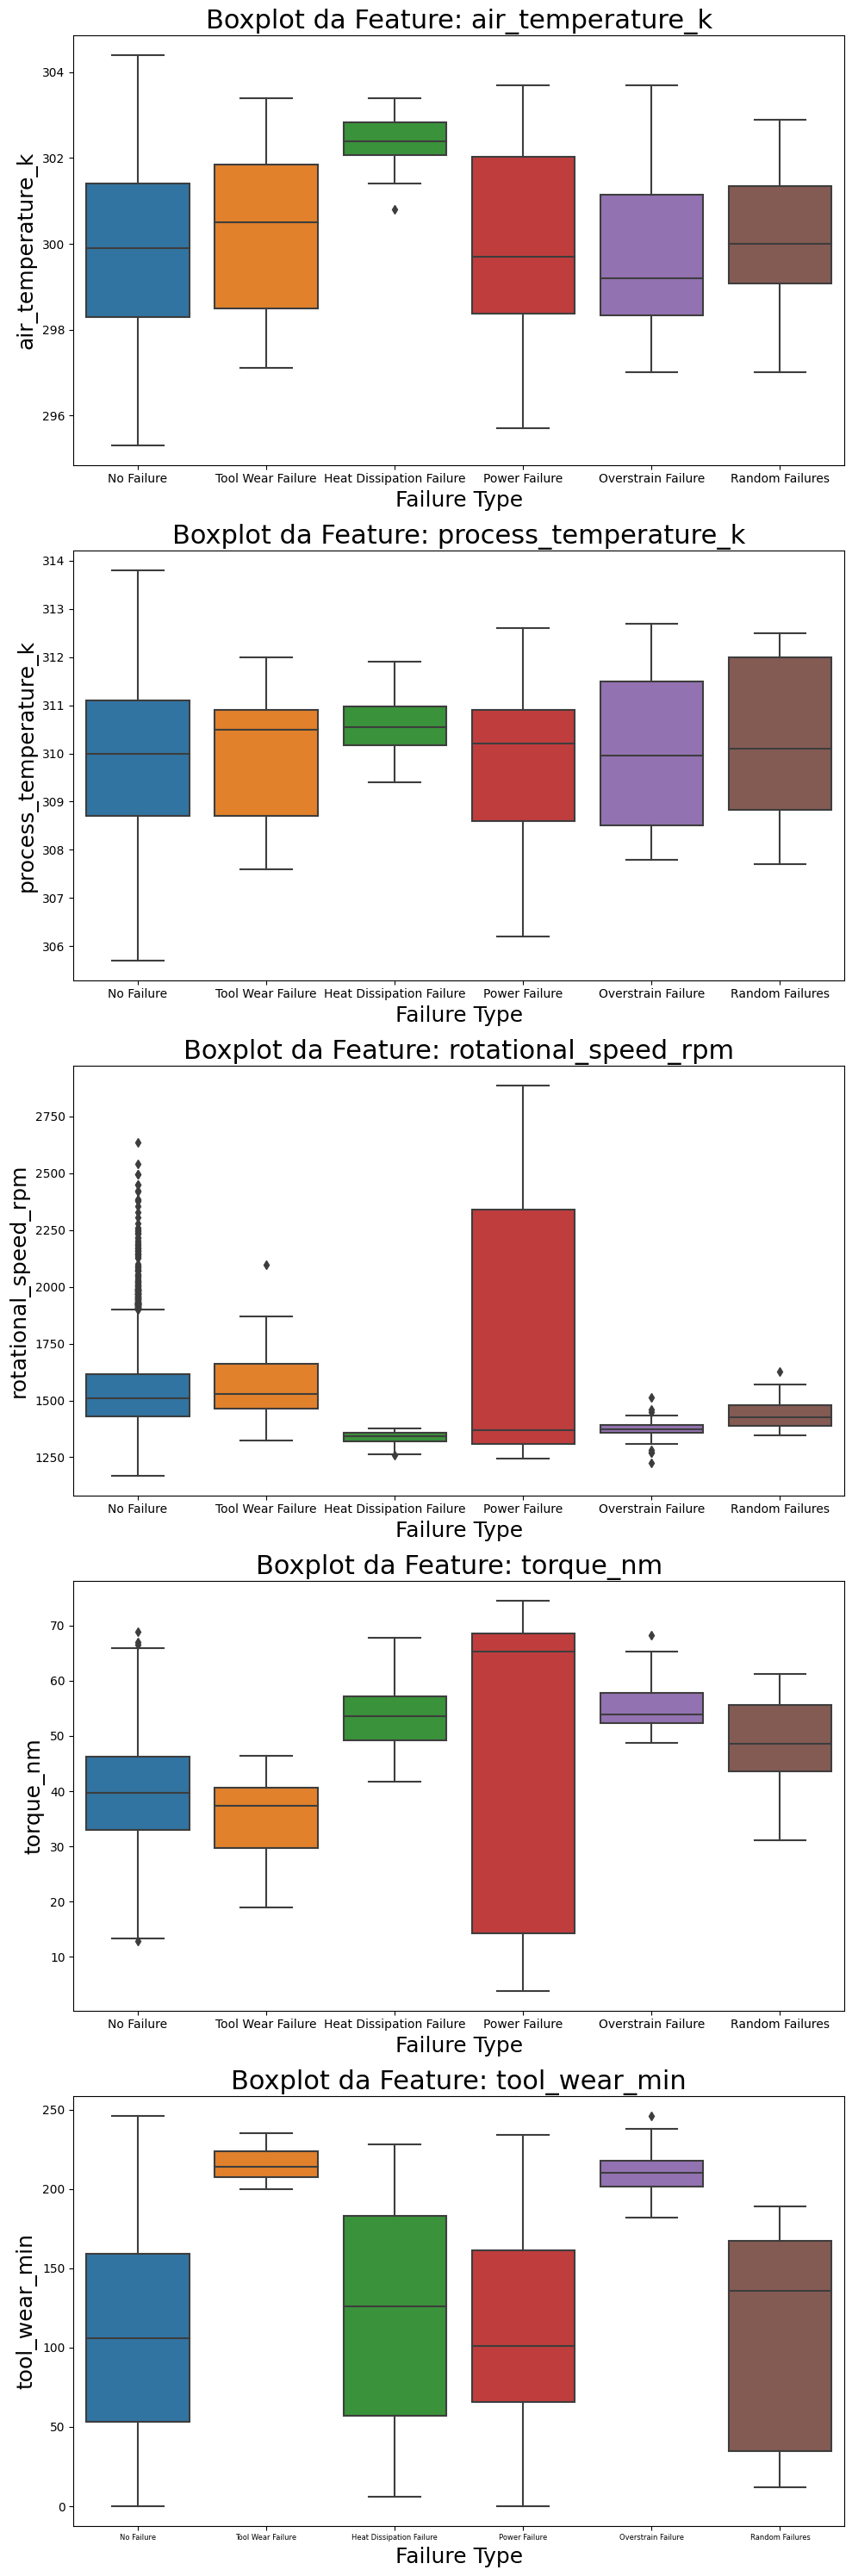

In [71]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 30))

for i, column in enumerate(numerical_features):
    ax = sns.boxplot(data=df_train, y=column, x='failure_type', ax=axes[i])
    ax.set_title(f'Boxplot da Feature: {column}', fontsize=22)
    ax.set_ylabel(column, fontsize=18)
    ax.set_xlabel('Failure Type', fontsize=18)
    plt.xticks(fontsize=6)
    
plt.tight_layout()
plt.show()

Por meio dos boxplots acima, é possível identificar padrões de comportamento das variáveis numéricas em relação ao tipo de falha, como estava descrito no dicionário dos dados

#### ii) Variáveis categóricas

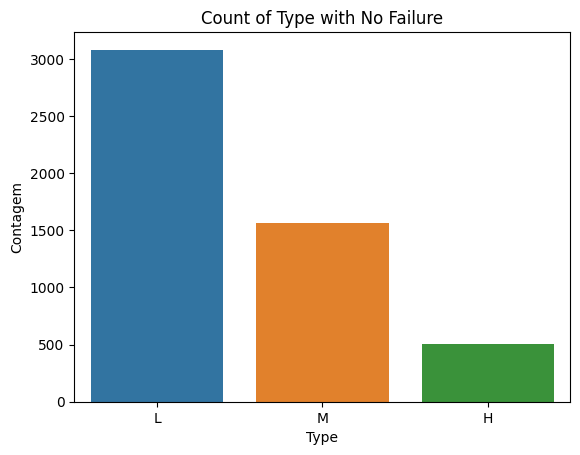

In [11]:
# Desenha o gráfico de barras agrupadas
sns.countplot(x='type', data=df_train[categorical_features][df_train['failure_type'] == 'No Failure'])

# Adiciona título, rótulos de eixos e legenda
plt.title('Count of Type with No Failure')
plt.xlabel('Type')
plt.ylabel('Contagem')

# Exibe o gráfico
plt.show()

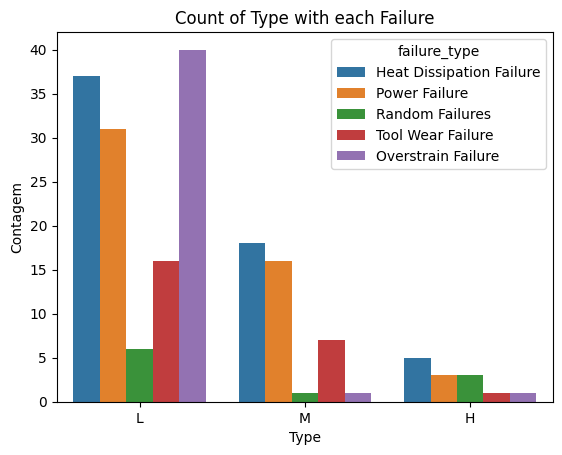

In [12]:
# Cria um gráfico de barras agrupadas
sns.countplot(x='type', hue='failure_type', data=df_train[categorical_features][df_train['failure_type'] != 'No Failure'])

# Adiciona título e rótulos de eixos
plt.title('Count of Type with each Failure')
plt.xlabel('Type')
plt.ylabel('Contagem')

# Exibe o gráfico
plt.show()

## 3 - Pipeline de preprocessamento

Durante a etapa de preprocessamento, o objetivo é preparar os dados para serem utilizados no modelo de machine learning. Nesta etapa, serão realizadas as seguintes etapas:

- Criação de novas features para o modelo
    - Criação da feature "power" que representa a potência da máquina ("rotational_speed_rpm" * "torque_nm")
    - Criação da feature "temp_diff" que representa a diferença entre a temperatura do processo e do ar
    - Criação da feature "overstrain" que representa a multiplicação entre "torque_nm" e "tool_wear_min"
    - Criação da feature "tool_wear_range" que atua como um booleano que indica se o valor de "tool_wear_min" está dentro do intervalo de valores de troca de ferramenta.
    
<br/>

- Codificação de valores categóricos
    - A codificação de valores categóricos foi realizada utilizando o método OneHotEncoder, que cria novas colunas para cada categoria da variável categórica, e atribui o valor 1 para a categoria que o dado pertence e 0 para as demais categorias.
    
<br/>

- Padronização de valores numéricos
    - A padronização de valores numéricos foi realizada utilizando o método StandardScaler, que transforma os dados de forma que a média seja 0 e o desvio padrão seja 1.

In [82]:
def create_pipeline(clf):
    """Cria a pipeline de pré-processamento do classificador com OneHotEncoder nas features categoricas

    Parameters
    ----------
    clf : estimator object
        Classificador que será utilizado na pipeline

    Returns
    -------
    pipe : Pipeline
        Pipeline de pré-processamento
    """

    def create_new_features(X):
        X1 = X.copy()
        X1['power'] = X1['rotational_speed_rpm'] * X1['torque_nm']
        X1['temp_diff'] = X1['process_temperature_k'] - X1['air_temperature_k']
        X1['overstrain'] = X1['torque_nm'] * X1['tool_wear_min']
        X1['tool_replace_range'] = 0
        X1.loc[(X1['tool_wear_min'] < 240) & (X1['tool_wear_min'] > 200), 'tool_replace_range'] = 1
        

        return X1
         

    multiply_transformer = FunctionTransformer(create_new_features, validate=False)

    categorical_selector = make_column_selector(dtype_exclude=np.number)
    numerical_selector = make_column_selector(dtype_include=np.number)

    encode_categorical = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), categorical_selector),
    (StandardScaler(), numerical_selector),
    )


    pipe = make_pipeline(multiply_transformer, encode_categorical,
                         clf)
    
    return pipe

## 4 - Modelos

Aqui serão desenvolvidas as pipelines para treinamento dos modelos, serão avaliados 3 modelos diferentes (LogisticRegression, RandomForest e XGBoost).
Para a otimização de hiperparâmetros será utilizada a função GridSearchCV do Scikit-learn que avalia o resultado para cada combinação de hiperparâmetros fornecida. Será utilizada uma validação cruzada de 3 folds buscando não ter um custo computacional muito elevado.

### Métrica utilizada

A métrica escolhida para avaliar a performance dos modelos foi o score F1, pois o dataset é extremamente desbalanceado, tornando a acurácia uma métrica não muito adequada para este problema. O score F1 é definido como sendo a média harmônica entre a precisão e o recall, sendo assim, é uma métrica que considera tanto a precisão quanto o recall, sendo que o recall é a capacidade do modelo de identificar todos os casos positivos, enquanto a precisão é a capacidade do modelo de identificar corretamente os casos positivos.

- $F1 = 2 \times \frac{precision \times recall}{precision + recall}$

- $precision = \frac{TP}{TP + FP}$

- $recall = \frac{TP}{TP + FN}$


Como temos uma classificação multiclasse, será adotada a média aritmética dos scores F1 para cada classe, que também é chamada de macro F1.

In [106]:
X_train = df_train.drop(['failure_type', 'product_id', 'udi'], axis=1)
y_train = df_train['failure_type']

X_val = df_val.drop(['failure_type', 'product_id', 'udi'], axis=1)
y_val = df_val['failure_type']

X_test = df_test.drop(['product_id', 'udi'], axis=1)


In [74]:
def base_model(clf, xgboost=False):
    """Cria a pipeline de pré-processamento e treina o classificador sem otimização de hiperparâmetros

    Parameters
    ----------
    clf : estimator object
        Classificador que será utilizado na pipeline
    xgboost: bool
        Se o classificador for XGBoost, é necessário fazer o LabelEncoder

    Returns
    -------
    pipe : Pipeline
        Pipeline de pré-processamento
    """

    pipe = create_pipeline(clf)

    if xgboost:
        le = LabelEncoder()
        encoded_labels = le.fit_transform(y_train)
        pipe.fit(X_train, encoded_labels)
        y_pred = pipe.predict(X_val)
        y_val_encoded = le.transform(y_val)
        
        return pipe, y_pred, y_val_encoded
    else:
        pipe.fit(X_train, y_train)
    

    return pipe


def perform_grid_search(pipe, param_grid, X_train, y_train, xgboost=False):
    """Realiza o GridSearchCV usando a pipeline e os parâmetros fornecidos

    Parameters
    ----------
    pipe : Pipeline
        Pipeline de pré-processamento
    param_grid : dict
        Dicionário de parâmetros para a busca
    X_train : array-like ou pd.DataFrame
        Features de treinamento
    y_train : array-like
        Variável alvo de treinamento
    xgboost: bool
        Se o classificador for XGBoost, é necessário fazer o LabelEncoder

    Returns
    -------
    gs : GridSearchCV
        Objeto GridSearchCV treinado
    """

    gs = GridSearchCV(
        pipe,
        param_grid,
        cv=3,
        scoring='f1_macro',
        return_train_score=True,
        n_jobs=-1,
    )

    if xgboost:
        le = LabelEncoder()
        encoded_labels = le.fit_transform(y_train)
        gs.fit(X_train, encoded_labels)
        y_pred = gs.predict(X_val)
        y_val_encoded = le.transform(y_val)
        
        return gs, y_pred, y_val_encoded
    else:
        gs.fit(X_train, y_train)

    return gs


def display_results(gs, param_grid):
    """Processa os resultados do GridSearch e exibe as 10 melhores combinações de hiperparâmetros com base no F1 Macro
    
    Parameters
    ----------
    gs : GridSearchCV
        Objeto GridSearchCV treinado
    param_grid : dict
        Dicionário de parâmetros para a busca
    """
    df = pd.DataFrame(gs.cv_results_)

    params = []
    for param in param_grid:
        param_name = param.split('__')[1]
        param_name = param_name.replace('_', ' ')
        param_name = param_name.title()
        params.append(param_name)
        df.rename(columns={f'param_{param}': param_name}, inplace=True)

    df.rename(columns={'mean_test_score': 'Mean Test F1 Macro',
                       'mean_train_score': 'Mean Train F1 Macro'}, inplace=True)

    df = df[['Mean Test F1 Macro', 'Mean Train F1 Macro'] + params]

    display(df.sort_values(by=['Mean Test F1 Macro'], ascending=False).head(10))


def model_tuning(clf, param_grid, X_train, y_train, xgboost=False):
    """Realiza o GridSearchCV usando o classificador e os parâmetros fornecidos

    Parameters
    ----------
    clf : estimator object
        Classificador que será utilizado no GridSearchCV
    param_grid : dict
        Dicionário de parâmetros para a busca
    X_train : array-like ou pd.DataFrame
        Features de treinamento
    y_train : array-like
        Variável alvo de treinamento
    xgboost: bool
        Se o classificador for XGBoost, é necessário fazer o LabelEncoder

    Returns
    -------
    gs : GridSearchCV
        Objeto GridSearchCV treinado
    """
    pipe = create_pipeline(clf)
    if xgboost:
        gs, y_pred, y_val_encoded = perform_grid_search(pipe, param_grid, X_train, y_train, xgboost=xgboost)
        display_results(gs, param_grid)
        return gs, y_pred, y_val_encoded
    else:
        gs = perform_grid_search(pipe, param_grid, X_train, y_train)
        display_results(gs, param_grid)

        return gs

def create_confusion_matrix(y_true, y_pred, labels):
    """Cria a matriz de confusão e exibe os resultados

    Parameters
    ----------
    y_true : array-like
        Variável alvo de teste
    y_pred : array-like
        Variável alvo prevista
    labels : list
        Lista de labels para a matriz de confusão
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    cmp.plot(ax=ax)

    plt.show();

### a) LogisticRegression

#### i) Modelo sem otimização de hiperparâmetros

In [107]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    pipe_lr = base_model(LogisticRegression(random_state=42, class_weight='balanced'))

    y_pred = pipe_lr.predict(X_val)

    print(classification_report(y_val, y_pred, zero_division=0, digits=3))

                          precision    recall  f1-score   support

Heat Dissipation Failure      0.283     1.000     0.441        15
              No Failure      0.999     0.689     0.816      1288
      Overstrain Failure      0.281     0.900     0.429        10
           Power Failure      0.455     0.769     0.571        13
         Random Failures      0.004     0.500     0.007         2
       Tool Wear Failure      0.075     0.833     0.137         6

                accuracy                          0.696      1334
               macro avg      0.349     0.782     0.400      1334
            weighted avg      0.974     0.696     0.802      1334



O modelo apresenta um resultado não muito interessante, tem mais problemas em classificar as classes Random Failures, Tool Wear Failure e Overstrain Failure.

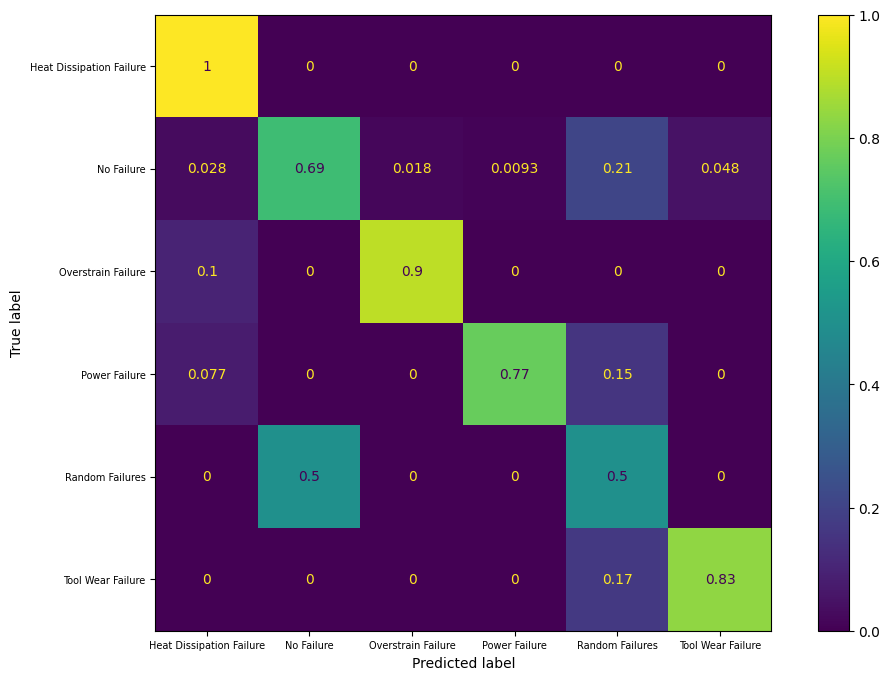

In [108]:
create_confusion_matrix(y_val, y_pred, pipe_lr.classes_)

Na matriz de confusão é possível observar as classes com maior taxa de erro, lembrando que a classe No Failure representa 96,5 % do dataset, tendo grande impacto na acurácia do modelo.

#### ii) Modelo com otimização

In [109]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    clf_lr = LogisticRegression(random_state=42, class_weight='balanced')

    param_grid_lr = {
        'logisticregression__C': np.logspace(2, 3, 15),
        'logisticregression__penalty': ['l2']
    }

    gs_lr = model_tuning(clf_lr, param_grid_lr, X_train, y_train)

,Mean Test F1 Macro,Mean Train F1 Macro,C,Penalty
5,0.478287,0.515544,227.584593,l2
9,0.478213,0.514684,439.397056,l2
10,0.477228,0.513699,517.947468,l2
14,0.476770,0.512860,1000.0,l2
13,0.476679,0.510297,848.342898,l2
7,0.476129,0.512038,316.227766,l2
8,0.475023,0.513063,372.759372,l2
12,0.474963,0.510673,719.685673,l2
2,0.474960,0.509281,138.949549,l2
11,0.474485,0.514518,610.54023,l2


In [110]:
y_pred = gs_lr.predict(X_val)

print(classification_report(y_val, y_pred, zero_division=0, digits=3))

                          precision    recall  f1-score   support

Heat Dissipation Failure      0.350     0.933     0.509        15
              No Failure      0.997     0.702     0.824      1288
      Overstrain Failure      0.321     0.900     0.474        10
           Power Failure      0.625     0.769     0.690        13
         Random Failures      0.004     0.500     0.007         2
       Tool Wear Failure      0.060     0.667     0.110         6

                accuracy                          0.706      1334
               macro avg      0.393     0.745     0.435      1334
            weighted avg      0.975     0.706     0.812      1334



Ao adicionar regularização, percebe-se que o modelo apresenta um resultado melhor, no entanto, ainda há problemas em classificar as classes Random Failures, Tool Wear Failure e Overstrain Failure. Dando sinais de underfitting, com baixo desempenho tanto no treino quanto na validação.

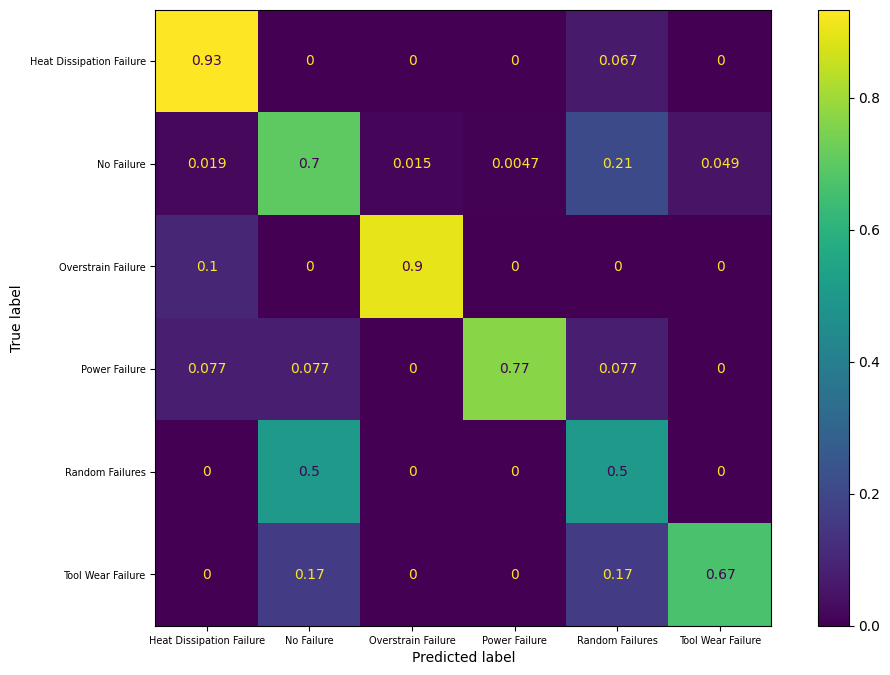

In [111]:
create_confusion_matrix(y_val, y_pred, gs_lr.best_estimator_.classes_)

### b) RandomForest

#### i) Modelo sem otimização de hiperparâmetros

In [112]:
pipe_rf = base_model(RandomForestClassifier(random_state=42, class_weight='balanced'))

y_pred = pipe_rf.predict(X_val)

print(classification_report(y_val, y_pred, zero_division=0, digits=3))

                          precision    recall  f1-score   support

Heat Dissipation Failure      1.000     0.733     0.846        15
              No Failure      0.989     0.999     0.994      1288
      Overstrain Failure      0.900     0.900     0.900        10
           Power Failure      1.000     0.923     0.960        13
         Random Failures      0.000     0.000     0.000         2
       Tool Wear Failure      0.000     0.000     0.000         6

                accuracy                          0.989      1334
               macro avg      0.648     0.593     0.617      1334
            weighted avg      0.983     0.989     0.986      1334



No modelo de RandomForest é possível notar um resultado melhor, no entanto, com problemas em classificar as classes Random Failures e Tool Wear Failure.

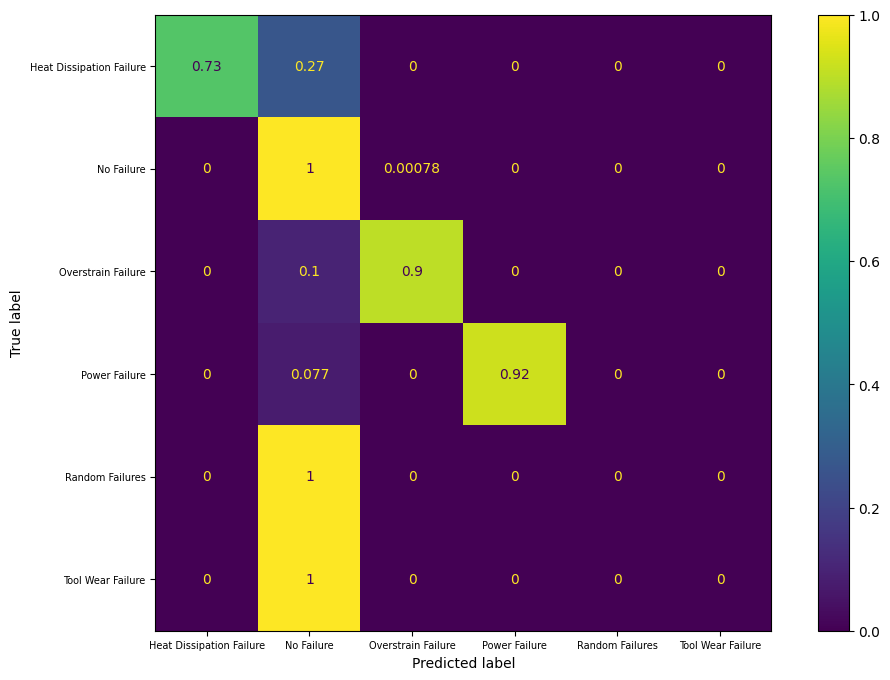

In [113]:
create_confusion_matrix(y_val, y_pred, pipe_rf.classes_)

#### ii) Modelo com otimização

In [158]:
clf_rf = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid_rf = {
            'randomforestclassifier__min_impurity_decrease': np.logspace(-5, -1, 10),
            'randomforestclassifier__max_depth': np.logspace(2, 8, num=10, base=2).astype(int),
            }

gs_rf = model_tuning(clf_rf, param_grid_rf, X_train, y_train)

,Mean Test F1 Macro,Mean Train F1 Macro,Min Impurity Decrease,Max Depth
11,0.650285,0.838824,0.000028,6
10,0.649400,0.839774,0.00001,6
12,0.647756,0.842214,0.000077,6
13,0.645212,0.822880,0.000215,6
24,0.644545,0.865940,0.000599,10
64,0.641910,0.867159,0.000599,64
84,0.641910,0.867159,0.000599,161
34,0.641910,0.867159,0.000599,16
74,0.641910,0.867159,0.000599,101
44,0.641910,0.867159,0.000599,25


Aplicando a otimização de hiperparâmetros percebe-se que o modelo ainda está com overfitting, pois o score F1 no treino é muito maior que o score F1 na validação, no entanto, o modelo melhorou seu resultado em relação ao modelo sem otimização. Nesse desafio não será feita uma otimização muito extensa, dado que o aumento do custo computacional não permitiria a realização do desafio no prazo.

In [159]:
y_pred = gs_rf.predict(X_val)

print(classification_report(y_val, y_pred, zero_division=0, digits=3))

                          precision    recall  f1-score   support

Heat Dissipation Failure      1.000     0.933     0.966        15
              No Failure      0.995     0.960     0.977      1288
      Overstrain Failure      0.909     1.000     0.952        10
           Power Failure      1.000     0.923     0.960        13
         Random Failures      0.000     0.000     0.000         2
       Tool Wear Failure      0.075     0.667     0.136         6

                accuracy                          0.957      1334
               macro avg      0.663     0.747     0.665      1334
            weighted avg      0.989     0.957     0.972      1334



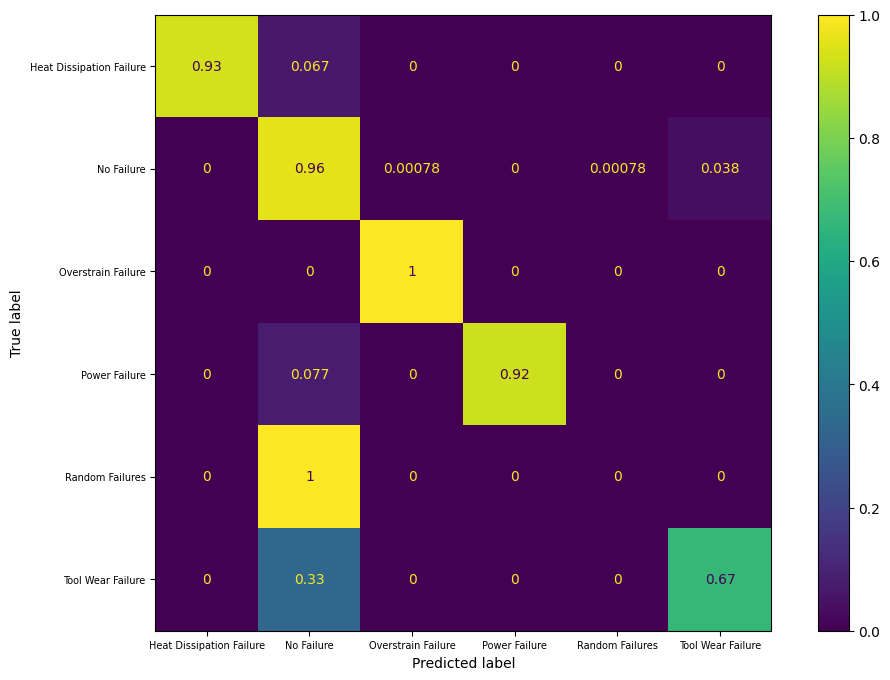

In [131]:
create_confusion_matrix(y_val, y_pred, gs_rf.best_estimator_.classes_)

### XGBoost

#### i) Modelo sem otimização de hiperparâmetros

In [117]:
pipe_xgb, y_pred, y_val_encoded = base_model(XGBClassifier(random_state=42), xgboost=True)

print(classification_report(y_val_encoded, y_pred, zero_division=0, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.800     0.889        15
           1      0.991     0.995     0.993      1288
           2      0.909     1.000     0.952        10
           3      1.000     1.000     1.000        13
           4      0.000     0.000     0.000         2
           5      0.000     0.000     0.000         6

    accuracy                          0.987      1334
   macro avg      0.650     0.633     0.639      1334
weighted avg      0.985     0.987     0.986      1334



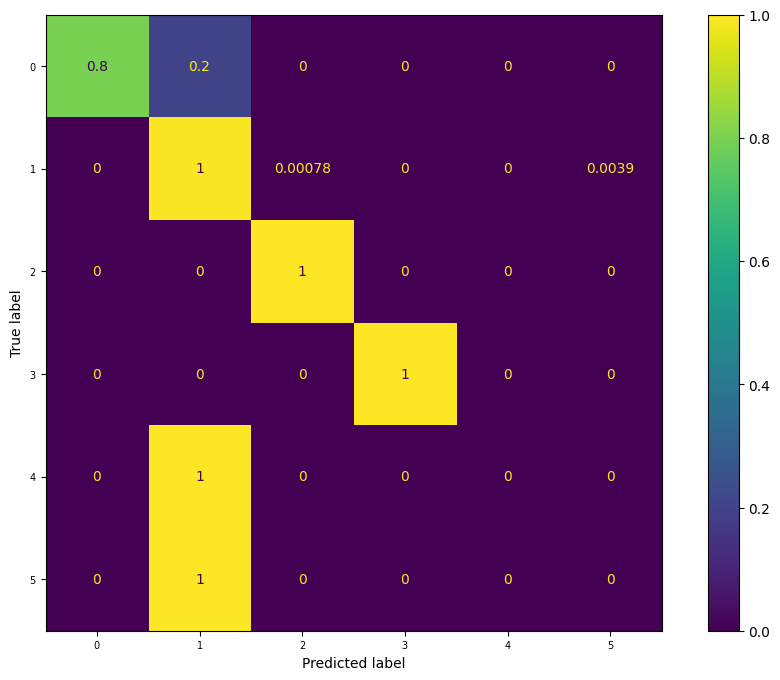

In [118]:
create_confusion_matrix(y_val_encoded, y_pred, pipe_xgb.classes_)

#### ii) Modelo com otimização

In [119]:
clf_xgb = XGBClassifier(random_state=42)

param_grid_xgb = {
    'xgbclassifier__learning_rate': np.logspace(-3, -1, 5),
    'xgbclassifier__max_depth': np.logspace(3, 5, num=3, base=2).astype(int),
    'xgbclassifier__gamma': np.logspace(-3, -1, 5),
}

gs_xgb, y_pred, y_val_encoded= model_tuning(clf_xgb, param_grid_xgb, X_train, y_train, xgboost=True)

,Mean Test F1 Macro,Mean Train F1 Macro,Learning Rate,Max Depth,Gamma
37,0.646074,0.715185,0.01,16,0.01
66,0.646074,0.710944,0.01,8,0.1
38,0.646074,0.715185,0.01,32,0.01
51,0.646074,0.710944,0.01,8,0.031623
36,0.646074,0.710944,0.01,8,0.01
52,0.646074,0.719041,0.01,16,0.031623
53,0.646074,0.719041,0.01,32,0.031623
23,0.646074,0.719041,0.01,32,0.003162
21,0.646074,0.710944,0.01,8,0.003162
22,0.646074,0.719041,0.01,16,0.003162


In [120]:
print(classification_report(y_val_encoded, y_pred, zero_division=0, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.800     0.889        15
           1      0.992     0.999     0.995      1288
           2      0.909     1.000     0.952        10
           3      1.000     1.000     1.000        13
           4      0.000     0.000     0.000         2
           5      0.000     0.000     0.000         6

    accuracy                          0.991      1334
   macro avg      0.650     0.633     0.639      1334
weighted avg      0.985     0.991     0.988      1334



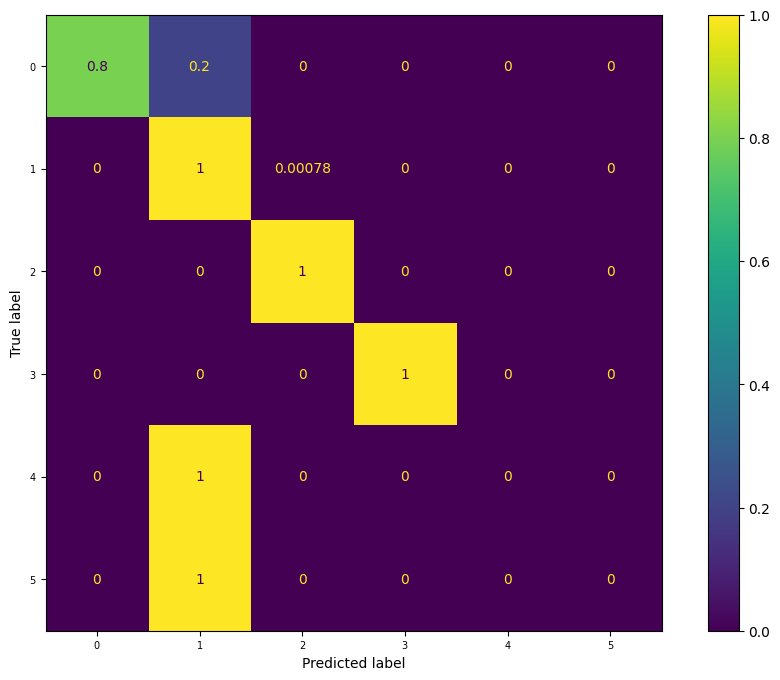

In [121]:
create_confusion_matrix(y_val_encoded, y_pred, gs_xgb.classes_)

## 5 - Conclusão

O melhor resultado obtido foi pelo modelo RandomForest com otimização (lembrando que não foram analisados todos os hiperparâmetros possíveis neste desafio, por questões de prazo, dado o aumento do custo computacional). O score F1 macro médio obtido foi de 0.665, o que é um resultado razoável, percebe-se que o modelo performa muito bem em todas as classes exceto nas duas que contém aleatoriedade na rotulação dos dados.

É importante ressaltar que a métrica utilizada para avaliação do modelo final deve ser discutida com o cliente interessado, pois o score F1 macro médio não é a única métrica que pode ser utilizada para avaliar a performance do modelo, por exemplo, se o cliente estiver mais interessado em identificar os defeitos de uma determinada classe, pode ser interessante utilizar o score F1 dessa classe, ou se o cliente estiver mais interessado em identificar todos os defeitos, pode ser interessante utilizar o recall macro médio.

In [155]:
gs_rf.best_estimator_.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

y_pred = gs_rf.best_estimator_.predict(X_test)

predicted = pd.concat([pd.Series(X_test.index.values), pd.Series(y_pred)], axis=1)
predicted.columns = ['rowNumber', 'predictedValues']

predicted.to_csv('predicted.csv', index=False)